In [1]:
# Install the headless version of OpenCV
!pip install opencv-python-headless
!pip install deepface
# Import necessary libraries
import cv2
import os
from google.colab import files
import shutil
import numpy as np
from deepface import DeepFace


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.5/105.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 9.8 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=fc49637b1d6272dd679f5a9fae857f7085909ddc467fefd193e0877a748bf8e3
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire
24-06-22 19:14:17 - Directory /root/.deepface created
24-06-22 19:14:17 - Directory /root/.deepface/weights created


In [21]:
def is_high_quality(face_img):
    if face_img.dtype != np.uint8:
        face_img = (face_img * 255).astype(np.uint8)
    gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var >= 100


def augment_face_data(face_data):
    augmented_faces = [face_data]
    for angle in [10, -10, 20, -20]:
        M = cv2.getRotationMatrix2D((face_data.shape[1]//2, face_data.shape[0]//2), angle, 1)
        rotated = cv2.warpAffine(face_data, M, (face_data.shape[1], face_data.shape[0]))
        augmented_faces.append(rotated)
    return augmented_faces

def extract_faces_data_from_video(video_path, detector_backend="retinaface", frame_rate=6):
    vidcap = cv2.VideoCapture(video_path)
    success, frame = vidcap.read()
    count = 0
    extracted_faces_data = []

    while success:
        if count % frame_rate == 0:
            detected_faces = DeepFace.extract_faces(img_path=frame, detector_backend=detector_backend, enforce_detection=False, anti_spoofing=True)
            if detected_faces:
                for face_info in detected_faces:
                    face_data = face_info['face']
                    if is_high_quality(face_data):
                        augmented_faces = augment_face_data(face_data)
                        extracted_faces_data.extend(augmented_faces)
        success, frame = vidcap.read()
        count += 1

    vidcap.release()
    print("Face extraction completed.")
    return extracted_faces_data



In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [22]:
video_path = "/content/drive/MyDrive/onboarding_video/WIN_20240615_13_45_46_Pro.mp4"
extracted_faces_data = extract_faces_data_from_video(video_path)


24-06-22 19:46:10 - Downloading MiniFASNetV2 weights to /root/.deepface/weights/2.7_80x80_MiniFASNetV2.pth


Downloading...
From: https://github.com/minivision-ai/Silent-Face-Anti-Spoofing/raw/master/resources/anti_spoof_models/2.7_80x80_MiniFASNetV2.pth
To: /root/.deepface/weights/2.7_80x80_MiniFASNetV2.pth
100%|██████████| 1.85M/1.85M [00:00<00:00, 12.5MB/s]


24-06-22 19:46:10 - Downloading MiniFASNetV2 weights to /root/.deepface/weights/4_0_0_80x80_MiniFASNetV1SE.pth


Downloading...
From: https://github.com/minivision-ai/Silent-Face-Anti-Spoofing/raw/master/resources/anti_spoof_models/4_0_0_80x80_MiniFASNetV1SE.pth
To: /root/.deepface/weights/4_0_0_80x80_MiniFASNetV1SE.pth
100%|██████████| 1.86M/1.86M [00:00<00:00, 12.5MB/s]


Face extraction completed.


In [ ]:
import matplotlib.pyplot as plt

# If you're using a Jupyter Notebook, include this line to display plots inline
%matplotlib inline


for f in extracted_faces_data :



    plt.imshow(f)

    plt.axis('off')  # Turn off axes
    plt.show()

In [25]:
print(len(extracted_faces_data))

190


In [9]:
# Ensure images are in the correct format
def preprocess_for_deepface(img):
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    return img

for x in extracted_faces_data:
    x = preprocess_for_deepface(x)



In [10]:
#now, I will make embeddings for these frames using arcface.
def extract_embeddings(face_data_list, model_name="ArcFace"):
    embeddings_list = []
    for face_data in face_data_list:
        # Generate embeddings for each face data using ArcFace
        embedding = DeepFace.represent(face_data, model_name=model_name, detector_backend="skip")[0]["embedding"]
        embeddings_list.append(embedding)
    return embeddings_list

In [11]:
embeds=extract_embeddings(extracted_faces_data)

24-06-22 19:18:24 - arcface_weights.h5 will be downloaded to /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5
100%|██████████| 137M/137M [00:01<00:00, 125MB/s]


In [ ]:
# now, packaging it into json along with a username and name (can be modified as need be); I am doing this because I plan on using mongodb
# for direct integration, ignore this portion for just the pipeline
import os
import json

def json_create_and_store(embeddings, username, name, folder_location):
    """
    Create a JSON file containing embeddings along with username and name,
    and store it in the specified folder.

    :param embeddings: Embedding list for one person.
    :param username: Username for the person.
    :param name: Name of the person.
    :param folder_location: Folder location to store the JSON file.
    """
    # Construct embeddings data
    embeddings_data = {
        "_id": username,  # Use username as unique identifier
        "name": name,
        "embeddings": embeddings
    }

    # Create JSON file name
    file_name = f"{username}_{name}_embeddings.json"

    # Store embeddings data in a JSON file
    with open(os.path.join(folder_location, file_name), "w") as json_file:
        json.dump(embeddings_data, json_file, indent=4)

    print(f"Embeddings data for {username} ({name}) stored in {file_name}")


In [ ]:
username = "catcache1" #ignore for just the pipeline
name = "Cat Cache"
folder_location = "/path/to/json_folder"
json_create_and_store(embeds, username, name, "/content/drive/MyDrive/user_jsons")

Embeddings data for catcache1 (Cat Cache) stored in catcache1_Cat Cache_embeddings.json


In [ ]:
test_image_loc="/content/drive/MyDrive/test_images_for_login_attempts/WIN_20240612_14_06_43_Pro.jpg";
#imagine the above was captured from livefeed after anti-spoofing measures were taken

In [26]:


def find_face_embedding(img_path, detector_backend='retinaface'):
    img = cv2.imread(img_path)  # Read the image
    detected_faces = DeepFace.extract_faces(img_path=img_path, detector_backend=detector_backend)
    max_area = 0
    max_face = None

    for face_info in detected_faces:
        facial_area = face_info['facial_area']
        face_area = facial_area['w'] * facial_area['h']

        if face_area > max_area:
            max_area = face_area
            max_face = face_info

    if max_face is not None and 'facial_area' in max_face:
        x, y, w, h = max_face['facial_area']['x'], max_face['facial_area']['y'], max_face['facial_area']['w'], max_face['facial_area']['h']
        face_img = img[y:y+h, x:x+w]  # Crop the face from the original image

        # Pass the cropped face image to DeepFace for embedding extraction
        embedding = DeepFace.represent(face_img, model_name='ArcFace', detector_backend='mtcnn')
        return embedding
    else:
        return None

    # this function will be run if anti-spoofing portion clears the input
#after anti-spoofing confirmation, a picture will be snapped.
#that picture has to be preprocessed and only the foreground subject that is looking into the camera has to be extracted
#then, embeddings of that person have to be created


In [27]:
def compare_embeddings(saved_embeddings, new_embedding):  #FINAL FUNCTION BEING USED RIGHT NOW (corresponds to last graph)
    # Initialize a list to store confidence scores
    confidence_scores = []

    # Get the actual embedding vector from the new_embedding dictionary
    new_embedding_vector = new_embedding[0].get('embedding')

    # Check if new_embedding_vector is a Numpy array
    #if isinstance(new_embedding_vector, np.ndarray):
        # Iterate through each saved embedding
    for saved_embedding in saved_embeddings:
            # Check if the saved embedding is a Numpy array
            #if isinstance(saved_embedding, np.ndarray):
                # Compare the saved embedding with the new embedding
                similarity_score = calculate_cosine_similarity(saved_embedding, new_embedding_vector)

                # Optionally, derive a confidence score from the similarity score
                confidence_scores.append(similarity_score)

    # Calculate the average confidence score
    if confidence_scores:
        if max(confidence_scores) > 0.7:
            average_confidence = max(confidence_scores)
        else:
            average_confidence = min(confidence_scores)
    else:
        average_confidence = 0.0  # Default value if no saved embeddings or invalid data

    return average_confidence


def calculate_cosine_similarity(embedding1, embedding2):
    """
    Calculates the cosine similarity between two embeddings (feature vectors).
    """
    # Normalize the embeddings to unit vectors
    embedding1 = embedding1 / np.linalg.norm(embedding1)
    embedding2 = embedding2 / np.linalg.norm(embedding2)

    # Calculate the cosine similarity
    cosine_similarity = np.dot(embedding1, embedding2)

    return cosine_similarity

In [28]:
#running a trial
trial_image_embeddings=find_face_embedding("/content/drive/MyDrive/test_images_for_login_attempts/WIN_20240612_14_06_43_Pro.jpg");

#I will retrieve the embeddings against the username from db
#but for now, embeds is the embeddings saved
ans=compare_embeddings(embeds,trial_image_embeddings);

1/1 [==============================] - 0s 18ms/step


In [29]:
print(ans)

0.7284924414479952


In [16]:
from PIL import Image
true_folder="/content/drive/MyDrive/test_folder/true"
false_folder="/content/drive/MyDrive/test_folder/false"


In [17]:
def process_folder(folder_path):
  values=[]
  for filename in os.listdir(folder_path):
    Image_path = os.path.join(folder_path, filename)
    value= compare_embeddings(embeds,find_face_embedding(Image_path))
    values.append(value)


  return values

In [19]:
true_values=process_folder(true_folder)
false_values=process_folder(false_folder)
true_values_rounded=np.round(np.array(true_values)/0.05)*0.05
false_values_rounded=np.round(np.array(false_values)/0.05)*0.05

1/1 [==============================] - 0s 19ms/step


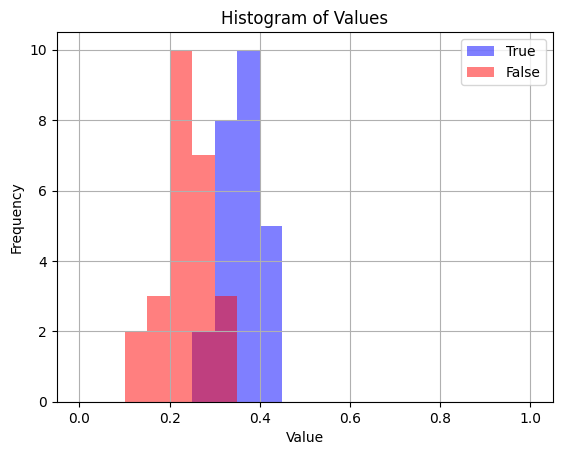

In [ ]:
# Plot histograms
bins = np.arange(0, 1.05, 0.05)
plt.hist(true_values_rounded, bins=bins, alpha=0.5, label='True', color='blue')
plt.hist(false_values_rounded, bins=bins, alpha=0.5, label='False', color='red')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

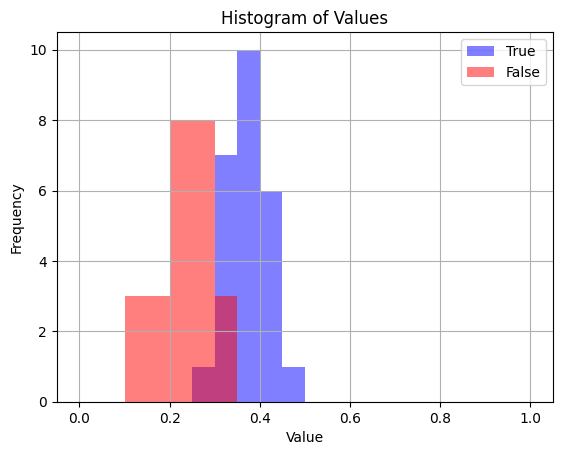

In [ ]:
# Plot histograms   #better preporcesssing
bins = np.arange(0, 1.05, 0.05)
plt.hist(true_values_rounded, bins=bins, alpha=0.5, label='True', color='blue')
plt.hist(false_values_rounded, bins=bins, alpha=0.5, label='False', color='red')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

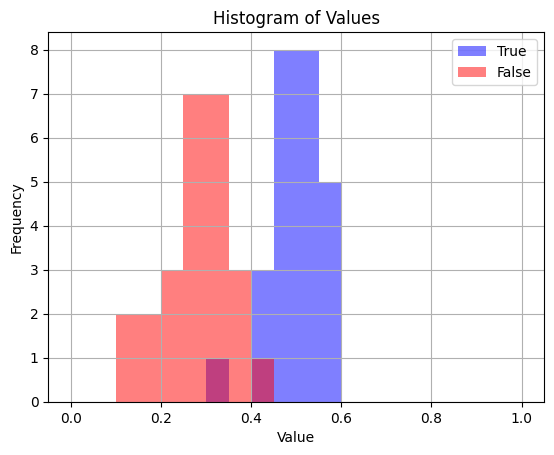

In [ ]:
# Plot histograms
bins = np.arange(0, 1.05, 0.05)
plt.hist(true_values_rounded, bins=bins, alpha=0.5, label='True', color='blue')
plt.hist(false_values_rounded, bins=bins, alpha=0.5, label='False', color='red')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

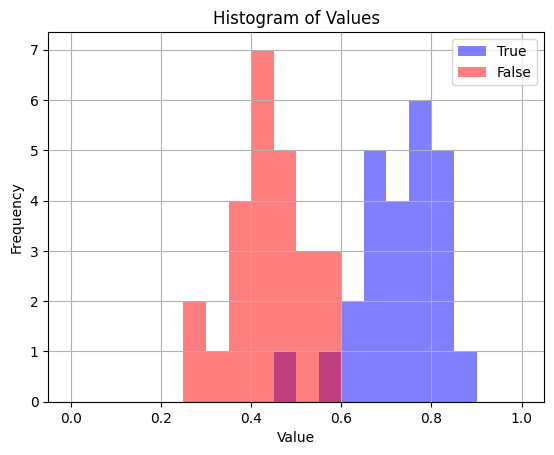

In [ ]:
# Plot histograms    #highest of all
bins = np.arange(0, 1.05, 0.05)
plt.hist(true_values_rounded, bins=bins, alpha=0.5, label='True', color='blue')
plt.hist(false_values_rounded, bins=bins, alpha=0.5, label='False', color='red')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

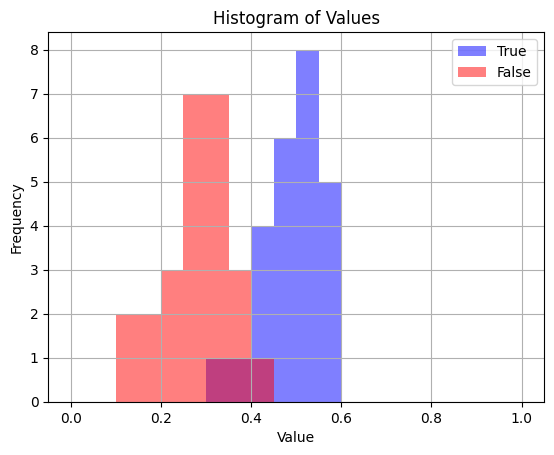

In [ ]:
# Plot histograms
bins = np.arange(0, 1.05, 0.05)
plt.hist(true_values_rounded, bins=bins, alpha=0.5, label='True', color='blue')
plt.hist(false_values_rounded, bins=bins, alpha=0.5, label='False', color='red')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

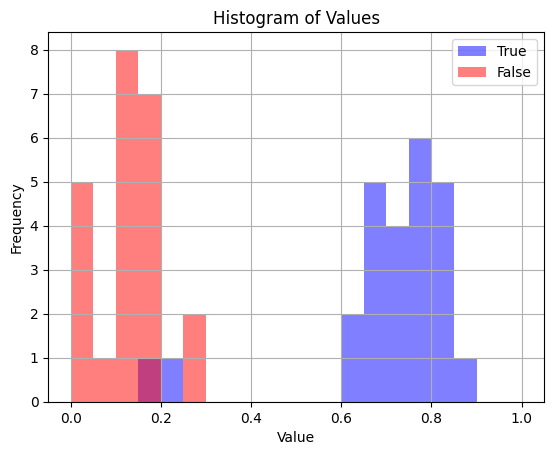

In [ ]:
# Plot histograms    #at 0.6 as well
bins = np.arange(0, 1.05, 0.05)
plt.hist(true_values_rounded, bins=bins, alpha=0.5, label='True', color='blue')
plt.hist(false_values_rounded, bins=bins, alpha=0.5, label='False', color='red')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

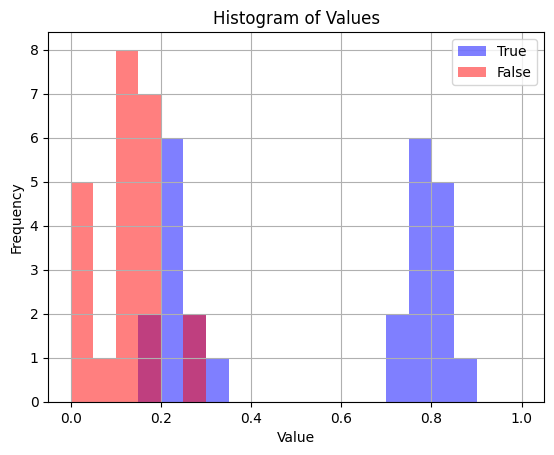

In [20]:
# Plot histograms                       #FINAL VERSION. THIS IS THE RESULT OF THE ABOVE CODE. THE OTHER GRAPHS ARE ACTING AS A PROGRESS REPORT FOR CHANGES.
bins = np.arange(0, 1.05, 0.05)
plt.hist(true_values_rounded, bins=bins, alpha=0.5, label='True', color='blue')
plt.hist(false_values_rounded, bins=bins, alpha=0.5, label='False', color='red')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()